In [11]:
import numpy as np
import scipy as sp
import torch

import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns

import os
import sys

#### load results, show table

In [12]:
seq2seq_model_path = '/Volumes/Samsung_T5/aoLab/Data/models/pyt/seq2seq/'
hp_sweep_path = os.path.join(seq2seq_model_path,'enc250_dec50_hps_20200523220302959000')
result_file = os.path.join(hp_sweep_path,'hps_results.csv')
result_df = pd.read_csv(result_file)
fig_save_path = './hps_20200528'

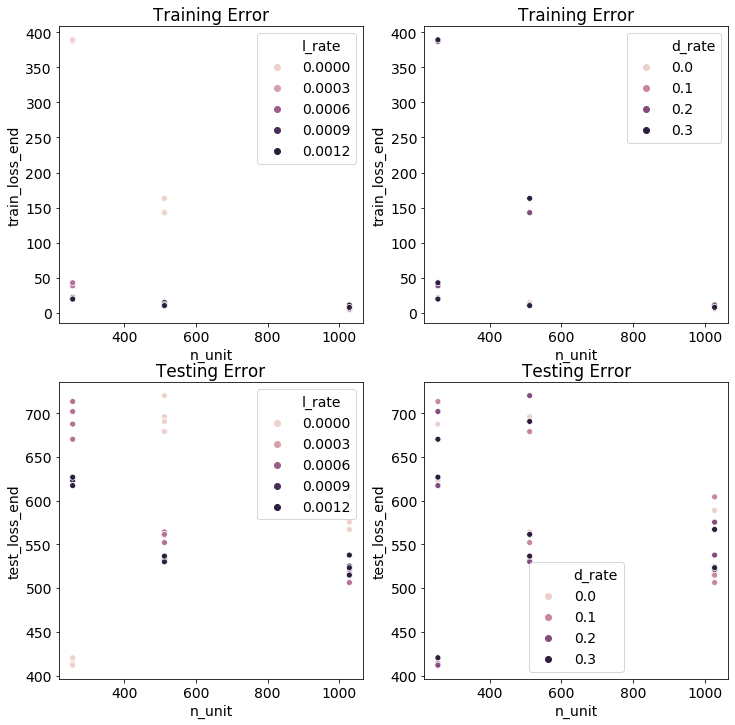

In [13]:
f,ax = plt.subplots(2,2,figsize=(12,12))
# plt.tight_layout()
sns.scatterplot(data=result_df, x="n_unit", y="train_loss_end", hue="l_rate", ax=ax[0,0])
ax[0,0].set_title('Training Error')
sns.scatterplot(data=result_df, x="n_unit", y="train_loss_end", hue="d_rate", ax=ax[0,1])
ax[0,1].set_title('Training Error')
sns.scatterplot(data=result_df, x="n_unit", y="test_loss_end", hue="l_rate", ax=ax[1,0])
ax[1,0].set_title('Testing Error')
sns.scatterplot(data=result_df, x="n_unit", y="test_loss_end", hue="d_rate", ax=ax[1,1])
ax[1,1].set_title('Testing Error')
f.savefig(os.path.join(fig_save_path,'train_test_error_all.png'))

It appears that n_unit is our big driver here, so let's look at the learning curves for each of those cases:

In [6]:
# get loop values, plot limits
n_units = np.unique(result_df.n_unit)
l_rate = np.unique(result_df.l_rate)
d_rate = np.unique(result_df.d_rate)
max_loss = np.max((result_df.train_loss_end.max(),result_df.test_loss_end.max()))
min_loss = np.min((result_df.train_loss_end.min(),result_df.test_loss_end.min()))

In [22]:
for n_u in n_units:
    rdf_ = result_df[result_df.n_unit == n_u]
    f,ax = plt.subplots(len(l_rate),len(d_rate),figsize=(24,16))
    for l_r_i, l_r in enumerate(l_rate):
        for d_r_i, d_r in enumerate(d_rate):
#             print('lr: {}\tdr: {}'.format(l_r,d_r))
            model_name = rdf_[np.logical_and(rdf_.l_rate==l_r,rdf_.d_rate==d_r)].iloc[0].id
            lc_data_file = os.path.join(hp_sweep_path,model_name,'training_progress.pt')
            lc_data = torch.load(lc_data_file)
            n_epoch = len(lc_data['train_loss'])
            epochs = np.arange(n_epoch)
            ax[l_r_i,d_r_i].plot(epochs,lc_data['train_loss'],'b.',label='train')
            ax[l_r_i,d_r_i].plot(epochs,lc_data['test_loss'],'r.',label='test')
            ax[l_r_i,d_r_i].set_title('lr: {} dr: {}'.format(l_r,d_r))
            ax[l_r_i,d_r_i].set_ylim([min_loss,max_loss*1.1])
    ax[0,len(d_rate)-1].legend(loc=0)
    ax[len(l_rate)-1,0].set_xlabel('epoch')
    ax[len(l_rate)-1,0].set_ylabel('MSE loss')
    f.savefig(os.path.join(fig_save_path,'learning_curves_nu_{}.png'.format(n_u)))
    plt.close(f)

In [10]:
# d_rate isn't doing anything. Fix at d_r = 0.1, plot all n_units + l_r on one figure
f,ax = plt.subplots(len(n_units),len(l_rate),figsize=(24,16))
d_r = d_rate[1]
for n_u_i, n_u in enumerate(n_units):
    for l_r_i, l_r in enumerate(l_rate):
        print('lr: {}\tdr: {}'.format(l_r,d_r))
        model_name = result_df[np.logical_and(result_df.l_rate==l_r,result_df.n_unit==n_u)].iloc[0].id
        lc_data_file = os.path.join(hp_sweep_path,model_name,'training_progress.pt')
        lc_data = torch.load(lc_data_file)
        n_epoch = len(lc_data['train_loss'])
        epochs = np.arange(n_epoch)
        ax[n_u_i,l_r_i].plot(epochs,lc_data['train_loss'],'b.',label='train')
        ax[n_u_i,l_r_i].plot(epochs,lc_data['test_loss'],'r.',label='test')
        ax[n_u_i,l_r_i].set_title('nu: {} lr: {}'.format(n_u,l_r))
        ax[n_u_i,l_r_i].set_ylim([min_loss,max_loss*1.1])
ax[0,len(l_rate)-1].legend(loc=0)
ax[len(n_units)-1,0].set_xlabel('epoch')
ax[len(n_units)-1,0].set_ylabel('MSE loss')
f.savefig(os.path.join(fig_save_path,'learning_curves_no_dr.png'))
plt.close(f)

lr: 0.0001	dr: 0.1
lr: 0.0005	dr: 0.1
lr: 0.001	dr: 0.1
lr: 0.0001	dr: 0.1
lr: 0.0005	dr: 0.1
lr: 0.001	dr: 0.1
lr: 0.0001	dr: 0.1
lr: 0.0005	dr: 0.1
lr: 0.001	dr: 0.1


### Best case!

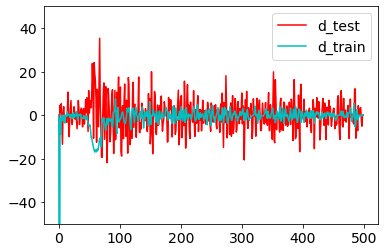

In [27]:
model_name = result_df[np.logical_and(result_df.l_rate==l_r,result_df.n_unit==n_u)].iloc[0].id
lc_data_file = os.path.join(hp_sweep_path,model_name,'training_progress.pt')
lc_data = torch.load(lc_data_file)
n_epoch = len(lc_data['train_loss'])
epochs = np.arange(n_epoch)
train_err_delta = np.zeros((n_epoch))
train_err_delta[1:-2] = (lc_data['train_loss'][2:-1] - lc_data['train_loss'][0:-3])/2
test_err_delta = np.zeros((n_epoch))
test_err_delta[1:-2] = (lc_data['test_loss'][2:-1] - lc_data['test_loss'][0:-3])/2
f,ax = plt.subplots(1,1,figsize=(6,4))
# ax.plot(epochs,lc_data['test_loss'],color='r',label='test')
ax.plot(epochs,test_err_delta,color='r',linestyle='-',label='d_test')
# ax.plot(epochs,lc_data['train_loss'],color='c',label='train')
ax.plot(epochs,train_err_delta,color='c',linestyle='-',label='d_train')
ax.set_ylim([-50,50])
ax.legend(loc=0)

There's a clear dip in the training error, while the difference estimate of the test error is noi-zee!